# CS 410 Final Project - Text Classification Competition

## Zhenchen Yu (zy23)

### Colab Setup
#### Skip this part if running at local machine

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
#Check if the mount is successful
#import os
#os.chdir('/content/gdrive/My Drive/Deep Learning/CS410_Final')
#!ls

# Part 1: Data Prep

## Load Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import random
import keras
from keras.layers import Dense, Dropout, LSTM,  BatchNormalization
from keras.layers import Activation, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.models import Sequential

Using TensorFlow backend.


In [4]:
document_path= 'data/train.jsonl'
def load_dataset(document_path):
    df = pd.read_json(document_path,lines=True)
    sentences = df.response.values
    labels = df.label.values 
    labels = np.where(labels=='SARCASM', 1, labels) 
    labels = np.where(labels=='NOT_SARCASM', 0, labels) 
    tokenized_texts = sentences
    return tokenized_texts,labels

In [5]:
tokenized_texts,labels = load_dataset(document_path)

#Remove stopwords
stop_word = open("stopwords.txt", "r")
stop_word = stop_word.read().splitlines()    
stop_word.append('@')
stop_word.append('user')

cv=CountVectorizer(stop_words=stop_word)
res_mrx=cv.fit_transform(tokenized_texts)
labels=np.asarray(labels).astype(None)
X_train, X_test, y_train, y_test = train_test_split(res_mrx, labels, test_size=0.2, random_state=42)

C:\Users\rayyu\AppData\Local\Continuum\anaconda3\envs\ml\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doesn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Prepare Prediction Data

In [6]:
test_path = 'data/test.jsonl'
df_test = pd.read_json(test_path,lines=True)
test_texts = df_test.response.values
res_test=cv.transform(test_texts)

#res_test is the test dataset
#Set cnn=true for cnn model prediction
#set rnn=true for rnn model prediction
def make_prediction(model, cnn=False, rnn=False):    
    if cnn==True:
        pred = model.predict(np.array(res_test.toarray()).reshape(res_test.shape[0],res_test.shape[1],1))
    elif rnn==True:
        pred = model.predict(np.array(res_test.toarray()).reshape(res_test.shape[0],1,res_test.shape[1]))
    else:
        pred = model.predict(res_test)
    
    if cnn==True or rnn==True:
        pred = np.where(pred>0.5,1,0)
    
    res=[]
    for i in range(len(pred)):
        if pred[i] == 0:
            res.append('NOT_SARCASM')
        else:
            res.append('SARCASM')

    twitter_id=[]
    for i in range(1800):
        twitter_id.append('twitter_' + str(i+1))

    results = zip(twitter_id,res)
    res2=[]
    for i ,j in results:
        res2.append(str(i)+','+str(j))
 
    with open('answer.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % place for place in res2)

# Part 2: Statistical Learning Models

## SVM

#### Linear Kernel

In [7]:
C_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c = 0, 0
for C in C_range:
    svm_li = SVC(kernel='linear',C=C)
    svm_li.fit(X_train, y_train)
    y_pred = svm_li.predict(X_test)
    if f1_score(y_test,y_pred) > best_f1:
        best_f1 = f1_score(y_test,y_pred)
        best_c = C
print("F1 Score for Linear SVM is", best_f1)

F1 Score for Linear SVM is 0.7601809954751132


#### Generate answer.txt

In [8]:
make_prediction(svm_li)

Final Prediction Result: 
Precision: 0.5800395256916996
Recall:    0.6522222222222223
F1 Score:  0.6140167364016738

#### RBF Kernel

In [9]:
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.01, 0.1, 1, 10, 100]
best_f1,best_c,best_gamma = 0,0,0
for C in C_range:
    for gamma in gamma_range:
        svm_rbf = SVC(kernel='rbf',C=C, gamma=gamma)
        svm_rbf.fit(X_train, y_train)
        y_pred = svm_rbf.predict(X_test)
        if f1_score(y_test,y_pred) > best_f1:
            best_f1 = f1_score(y_test,y_pred)
            best_c = C
            best_gamma = gamma
print("F1 Score for RBF SVM is",best_f1)

F1 Score for RBF SVM is 0.7586206896551725


#### Generate answer.txt

In [10]:
make_prediction(svm_rbf)

Final Prediction Result: 
Precision: 0.500277932184547
Recall:    1
F1 Score:  0.6669136717302705

### Random Forest

In [11]:
best_f1, best_n = 0, 0
for n_est in range(10,100,2):
    clf_rf = RandomForestClassifier(max_depth = 3, random_state=0, n_estimators = n_est)
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    if f1_score(y_test,y_pred) > best_f1:
        best_f1 = f1_score(y_test,y_pred)
        best_n = n_est
print("F1 Score for Random Forest is",best_f1)

F1 Score for Random Forest is 0.7321578505457599


In [12]:
make_prediction(clf_rf)

Final Prediction Result: 
Precision: 0.5672609400324149
Recall:    0.7777777777777778
F1 Score:  0.6560449859418931

### XGBoost

In [13]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
best_f1 = f1_score(y_test,y_pred)
print("F1 Score for XGBoost is",best_f1)

F1 Score for XGBoost is 0.7440585009140768


In [14]:
make_prediction(xgboost_model)

Final Prediction Result: 
Precision: 0.5838198498748958
Recall:    0.7777777777777778
F1 Score:  0.6669842782277275

### Logistic Regression

In [15]:
C_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c = 0, 0
for C in C_range:
    clf_lr = LogisticRegression(random_state=0, solver='liblinear', C=C).fit(X_train, y_train)
    clf_lr.fit(X_train, y_train)
    y_pred = clf_lr.predict(X_test)
    if f1_score(y_test,y_pred) > best_f1:
        best_f1 = f1_score(y_test,y_pred)
        best_c = C
print("F1 Score for Logistic Regression is", best_f1)

F1 Score for Logistic Regression is 0.7566089334548769


In [16]:
make_prediction(clf_lr)

Final Prediction Result: 
Precision: 0.5896180215475024
Recall:    0.6688888888888889
F1 Score:  0.6267568974492451

## Part 3: Deep Learning Models

### CNN

In [17]:
def create_model(xtrain, ytrain):
    model=Sequential()
    model.add(Conv1D(32,1,input_shape=xtrain.shape[1:]))
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(32,1))
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dense(1, activation='sigmoid'))    
    return model

In [18]:
# Parameters
EPOCHS=50
BATCH_SIZE=64

In [19]:
xtrain = np.array(X_train.toarray()).reshape(X_train.shape[0],X_train.shape[1],1)
ytrain=np.array(y_train)
xtest = np.array(X_test.toarray()).reshape(X_test.shape[0],X_test.shape[1],1)

In [20]:
# Train Model
cnn_model=create_model(xtrain,ytrain)
cnn_model.compile(loss='binary_crossentropy',
         optimizer=keras.optimizers.Adam(lr=0.00001, epsilon=1e-06),
         metrics=['accuracy'])
cnn_hist=cnn_model.fit(xtrain,ytrain,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(xtest,y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6917 - acc: 0.5277 - val_loss: 0.6908 - val_acc: 0.5530
Epoch 2/50
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6887 - acc: 0.5790 - val_loss: 0.6883 - val_acc: 0.5650
Epoch 3/50
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6846 - acc: 0.6195 - val_loss: 0.6842 - val_acc: 0.6190
Epoch 4/50
4000/4000 [==============================] - 19s 5ms/step - loss: 0.6787 - acc: 0.6933 - val_loss: 0.6791 - val_acc: 0.6700
Epoch 5/50
4000/4000 [==============================] - 18s 4ms/step - loss: 0.6721 - acc: 0.7340 - val_loss: 0.6739 - val_acc: 0.6900
Epoch 6/50
4000/4000 [==============================] - 19s 5ms/step - loss: 0.6655 - acc: 0.7375 - val_loss: 0.6687 - val_acc: 0.6930
Epoch 7/50
4000/4000 [

In [21]:
#If using colab, set colab=True. If running at local, set colab=False
def show_metrics(r,colab=False):
    _,axes=plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(r.history['loss'], label='Train Loss')
    axes[0].plot(r.history['val_loss'], label='Val Loss')
    axes[0].legend()
    axes[0].set_title('Loss')
    if colab==False:
        axes[1].plot(r.history['acc'], label='Train Acc')
        axes[1].plot(r.history['val_acc'], label='Val Acc')
        axes[1].legend()
        axes[1].set_title('Acc')
    else:
        axes[1].plot(r.history['accuracy'], label='Train Acc')
        axes[1].plot(r.history['val_accuracy'], label='Val Acc')
        axes[1].legend()
        axes[1].set_title('Accuracy')

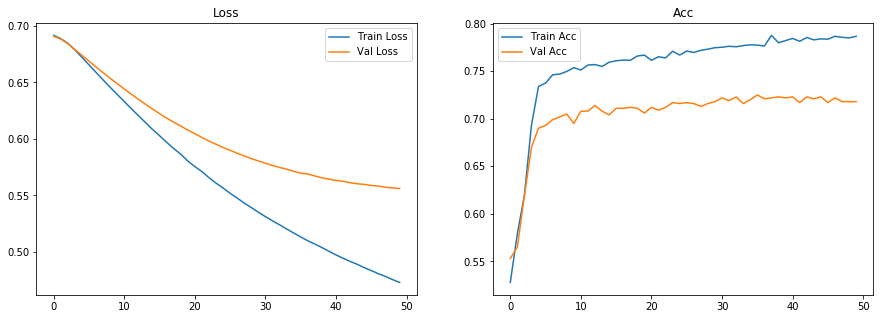

In [22]:
show_metrics(cnn_hist)

In [23]:
y_pred = cnn_model.predict(xtest)
y_pred = np.where(y_pred>0.5,1,0)
print("F1 Score for CNN is", f1_score(y_pred,y_test))

F1 Score for CNN is 0.7354596622889307


In [24]:
make_prediction(cnn_model,cnn=True)

Final Prediction Result:
Precision: 0.6003521126760564
Recall:    0.7577777777777778
F1 Score:  0.6699410609037328

### RNN + LSTM

In [25]:
xtrain = np.array(X_train.toarray()).reshape(X_train.shape[0],1,X_train.shape[1])
xtest = np.array(X_test.toarray()).reshape(X_test.shape[0],1,X_test.shape[1])

In [26]:
def create_model_rnn(xtrain):
    model=Sequential()
    model.add(LSTM(256, input_shape=(xtrain.shape[1:]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(256))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [27]:
EPOCHS=5
BATCH_SIZE = 64
rnn_model=create_model_rnn(xtrain)
rnn_model.compile(loss='binary_crossentropy',
          optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-6),
          metrics=['accuracy'])
rnn_hist = rnn_model.fit(xtrain,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(xtest,y_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 22s 6ms/step - loss: 0.7535 - acc: 0.5703 - val_loss: 0.6264 - val_acc: 0.6460
Epoch 2/5
4000/4000 [==============================] - 17s 4ms/step - loss: 0.6029 - acc: 0.6763 - val_loss: 0.5836 - val_acc: 0.6910
Epoch 3/5
4000/4000 [==============================] - 17s 4ms/step - loss: 0.4846 - acc: 0.7657 - val_loss: 0.5636 - val_acc: 0.7230
Epoch 4/5
4000/4000 [==============================] - 17s 4ms/step - loss: 0.3665 - acc: 0.8393 - val_loss: 0.5659 - val_acc: 0.7360
Epoch 5/5
4000/4000 [==============================] - 17s 4ms/step - loss: 0.2819 - acc: 0.8822 - val_loss: 0.5956 - val_acc: 0.7390


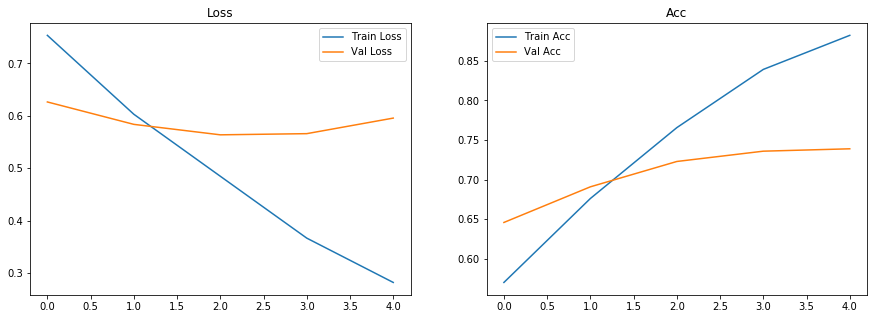

In [28]:
show_metrics(rnn_hist,colab=False)

In [29]:
y_pred = rnn_model.predict(xtest)
y_pred = np.where(y_pred>0.5,1,0)
print("F1 Score for RNN is", f1_score(y_pred,y_test))

F1 Score for RNN is 0.7502392344497608


In [30]:
make_prediction(rnn_model,rnn=True)

Final Prediction Result:
Precision: 0.5967878275570583
Recall:    0.7844444444444445
F1 Score:  0.6778684589534325